In [2]:
import numpy as np
from numpy import pi
import os

# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Qiskit AerSimulator import
from qiskit_aer import AerSimulator

#Noice
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2 #Virtual backend

# Transiplation/optimization ISA
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import Layout

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from qiskit.visualization import circuit_drawer

# Backend selection
backend = FakeWashingtonV2()
fake = FakeWashingtonV2()
noise_model = NoiseModel.from_backend(fake)
simulator = AerSimulator.from_backend(FakeWashingtonV2())

print(f"Selected virtual backend: {backend.name}")

ModuleNotFoundError: No module named 'qiskit'

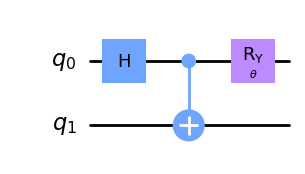

In [ ]:
# ╔══════════════════════════════════╗
# ║ 1. PARAMETRIZED CIRCUIT BUILDING ║
# ╚══════════════════════════════════╝

theta = Parameter("$\\theta$")

qc_param = QuantumCircuit(2)
qc_param.h(0)          # Bell |Φ+> state preparation
qc_param.cx(0, 1)
qc_param.ry(theta, 0)  #RY(θ) on the two qubit

qc_param.draw(output="mpl", idle_wires=False, style="clifford",filename="qc_param.svg")    #Print & save circuit

In [ ]:
# ╔════════════════════════════════════════════╗
# ║ 2. OBSERVABLE DEFINITION - PHASES CREATION ║
# ╚════════════════════════════════════════════╝
chsh1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
chsh2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

num_phases = 30
phases = np.linspace(0, 2 * pi, num_phases)
param_bindings = [[phase] for phase in phases]

#check parameter variation
print(param_bindings)
print(len(param_bindings))

print("\nOsservabili CHSH:")
print("CHSH1:", chsh1)
print("CHSH2:", chsh2)

[[np.float64(0.0)], [np.float64(0.21666156231653746)], [np.float64(0.43332312463307493)], [np.float64(0.6499846869496124)], [np.float64(0.8666462492661499)], [np.float64(1.0833078115826873)], [np.float64(1.2999693738992248)], [np.float64(1.5166309362157622)], [np.float64(1.7332924985322997)], [np.float64(1.9499540608488373)], [np.float64(2.1666156231653746)], [np.float64(2.383277185481912)], [np.float64(2.5999387477984497)], [np.float64(2.8166003101149872)], [np.float64(3.0332618724315243)], [np.float64(3.249923434748062)], [np.float64(3.4665849970645994)], [np.float64(3.683246559381137)], [np.float64(3.8999081216976745)], [np.float64(4.116569684014212)], [np.float64(4.333231246330749)], [np.float64(4.549892808647287)], [np.float64(4.766554370963824)], [np.float64(4.983215933280362)], [np.float64(5.199877495596899)], [np.float64(5.416539057913437)], [np.float64(5.6332006202299745)], [np.float64(5.849862182546511)], [np.float64(6.066523744863049)], [np.float64(6.283185307179586)]]
30

O

In [ ]:
#BACKEND TOPOLOGY
config = backend.configuration()
coupling_map = config.coupling_map
print("Coupling Map:", coupling_map)       #show qubits hardware structure

Coupling Map: [[0, 1], [0, 14], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 15], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 16], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 17], [13, 12], [14, 0], [14, 18], [15, 4], [15, 22], [16, 8], [16, 26], [17, 12], [17, 30], [18, 14], [18, 19], [19, 18], [19, 20], [20, 19], [20, 21], [20, 33], [21, 20], [21, 22], [22, 15], [22, 21], [22, 23], [23, 22], [23, 24], [24, 23], [24, 25], [24, 34], [25, 24], [25, 26], [26, 16], [26, 25], [26, 27], [27, 26], [27, 28], [28, 27], [28, 29], [28, 35], [29, 28], [29, 30], [30, 17], [30, 29], [30, 31], [31, 30], [31, 32], [32, 31], [32, 36], [33, 20], [33, 39], [34, 24], [34, 43], [35, 28], [35, 47], [36, 32], [36, 51], [37, 38], [37, 52], [38, 37], [38, 39], [39, 33], [39, 38], [39, 40], [40, 39], [40, 41], [41, 40], [41, 42], [41, 53], [42, 41], [42, 43], [43, 34], [43, 42], [43, 44], [44, 43], [44, 45], [45, 44], [45, 46], [45, 54], [46, 

In [ ]:
# ╔════════════════════════════════╗
# ║ 3. LOOKING FOR BEST QUBIT PAIR ║
# ╚════════════════════════════════╝

props = fake.properties()
'''
# To see T_1/T_2 of each qubit
for i, qubits in enumerate(props.qubits):
    t1 = next(p.value for p in qubits if p.name=='T1')
    t2 = next(p.value for p in qubits if p.name=='T2')
    print(f"qubit {i}: T1={t1:.1f}µs, T2={t2:.1f}µs")

#To see CNOT gate error of each quibit pairs:
for gate in props.gates:
    if gate.gate=='cx':
        err = next(p.value for p in gate.parameters if p.name=='gate_error')
        print(f"cx on {gate.qubits}: error={err:.3%}")
'''
errors = []
for gate in props.gates:
    if gate.gate == "cx":
        e = next(p.value for p in gate.parameters if p.name=="gate_error")
        errors.append((tuple(gate.qubits), e))

# 2) Ordering and considering the first 10 best qubits pairs
errors_sorted = sorted(errors, key=lambda x: x[1])
top10 = errors_sorted[:10]

print("Best 10 CX pairs with lower gate_error:")
for (qpair, err) in top10:
    print(f"  qubits {qpair!r} → errore {err:.3%}")

# 3) Choose the best layout pair
best_qubits = top10[0][0]
print("Use as initial_layout:", best_qubits)


Best 10 CX pairs with lower gate_error:
  qubits (101, 100) → errore 0.524%
  qubits (100, 101) → errore 0.524%
  qubits (19, 20) → errore 0.594%
  qubits (20, 19) → errore 0.594%
  qubits (51, 36) → errore 0.608%
  qubits (36, 51) → errore 0.608%
  qubits (1, 2) → errore 0.617%
  qubits (2, 1) → errore 0.617%
  qubits (57, 58) → errore 0.621%
  qubits (58, 57) → errore 0.621%
Use as initial_layout: (101, 100)


/usr/local/lib/python3.11/dist-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


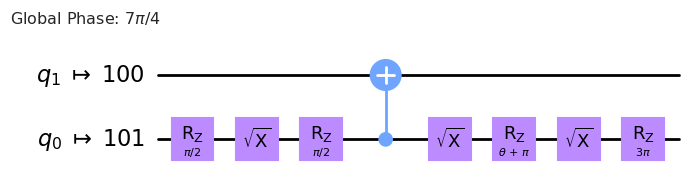

In [ ]:
# ╔══════════════════════════════════════════════════════════╗
# ║ 4. ISA OPTIMIZATION (transpiler) ON PARAMETRIZED CIRCUIT ║
# ╚══════════════════════════════════════════════════════════╝

target = simulator.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
basis_gates = ["rz","sx","cx","id"]     #force to take into account this basis

#chsh_isa_circuit = pm.run(qc_param)
chsh_isa_circuit = transpile(qc_param,
                             backend=simulator,
                             layout_method='trivial',     #force to take the initial_layout
                             initial_layout=best_qubits,    #change values according to the best pair found
                             optimization_level=3, basis_gates=basis_gates, seed_transpiler=42)

isa_observable1 = chsh1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = chsh2.apply_layout(layout=chsh_isa_circuit.layout)

chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="clifford",filename="isa_circuit.svg")  #print & save the circuit

In [ ]:
# ╔═══════════════════════════════════════════╗
# ║ 5. SINGLE "pub" ESTIMATOR - JOB EXECUTION ║
# ╚═══════════════════════════════════════════╝
estimator = Estimator(simulator)
estimator.options.resilience_level = 2
estimator.options.default_shots = 100000

pubs = [
    (chsh_isa_circuit, [isa_observable1], param_bindings),
    (chsh_isa_circuit, [isa_observable2], param_bindings),
]

job = estimator.run(pubs=pubs)
result = job.result()

# Estrazione risultati corretta
chsh1_vals = result[0].data.evs.ravel()  # Shape (30,)
chsh2_vals = result[1].data.evs.ravel()  # Shape (30,)

print("CHSH1 Values:", chsh1_vals)
print("CHSH2 Values:", chsh2_vals)

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


CHSH1 Values: [ 1.7497425   1.33082669  0.85297147  0.32817672 -0.20155798 -0.71727283
 -1.21700783 -1.64066359 -2.00099999 -2.26865731 -2.42093579 -2.46471535
 -2.38599614 -2.20333797 -1.92306077 -1.5396046  -1.09622904 -0.59411406
 -0.0797792   0.46915531  0.97167028  1.44150558  1.83450165  2.14727853
  2.35913641  2.45871541  2.43841562  2.30447696  2.07851921  1.74774252]
CHSH2 Values: [ 1.74530255  2.07407926  2.32353676  2.43853561  2.46091539  2.35425646
  2.14925851  1.83578164  1.43568564  0.97575024  0.46813532 -0.06281937
 -0.59293407 -1.09470905 -1.53716463 -1.92094079 -2.20849792 -2.39317607
 -2.46471535 -2.43055569 -2.2699573  -1.99850001 -1.65230348 -1.22114779
 -0.72347277 -0.19893801  0.33083669  0.85671143  1.32628674  1.75422246]


In [ ]:
# ╔════════════════════════════╗
# ║ 6. S PARAMETER COMPUTATION ║
# ╚════════════════════════════╝

S_values = np.maximum(np.abs(chsh1_vals), np.abs(chsh2_vals))
S_max = np.max(S_values)

S_mean = np.mean(S_values)
S_std = np.std(S_values, ddof=1)

print("\n" + "═"*26)
print("CHSH Results:")
print("═"*26)
print("S parameters for each binding:", S_values)
print(f"Maximum Bell violation (S_max): {S_max:.4f}")
# Mean and standard dev
print(f"S mean value: {S_mean:.4f} ± {S_std:.4f}")

# ╔═══════════════════╗
# ║ 7. ERROR ANALYSIS ║
# ╚═══════════════════╝
print("\nError analysis:")
properties = fake.properties()

# mean gate errors
#cx_errors = [properties.gate_error('cx', [int(q[0]), int(q[1])])
#             for q in properties.gates if q.gate == 'cx' and len(q.qubits) == 2]
#avg_cx_error = np.mean(cx_errors) if cx_errors else 0

rz_errors = [properties.gate_error('rz', q) for q in range(backend.configuration().num_qubits)]
avg_rz_error = np.mean(rz_errors) if rz_errors else 0

avg_rz_error = np.mean(rz_errors) if rz_errors else 0

sx_errors = [properties.gate_error('sx', q) for q in range(backend.configuration().num_qubits)]
avg_sx_error = np.mean([properties.gate_error('sx', q) for q in range(backend.configuration().num_qubits)])

# Reading errors
readout_errors = [properties.readout_error(q) for q in range(backend.configuration().num_qubits)]
avg_readout_error = np.mean(readout_errors) if readout_errors else 0

#print(f"Mean CX gate error: {avg_cx_error:.4f}")
print(f"Mean RZ gate error: {avg_rz_error:.4f}")
print(f"Mean SX gate error: {avg_sx_error:.4f}")
print(f"Mean reading error: {avg_readout_error:.4f}")

# ╔═════════════════════════════╗
# ║ 8. CRYTICAL ANALYSIS RESULT ║
# ╚═════════════════════════════╝
print("\n" + "═"*26)
print("Critical analysis results")
print("═"*26)
print(f"1. Inequality violation: {S_max > 2}")
print(f"   - Theoretical expected value: 2√2 ≈ {2*np.sqrt(2):.4f}")
print(f"   - Experimental value: {S_max:.4f}")
print(f"   - Deviation: {(2*np.sqrt(2) - S_max):.4f}")

print("\n2. Main errors sources:")
#print(f"   - Error gate (CX): extimated contribution ~{avg_cx_error*100:.2f}% for each operation")
print(f"   - Reading error: extimated contribution ~{avg_readout_error*100:.2f}% for each qubit")
print("   - Dechoerence: choerence loss")
print("   - Calibration errors: gate parameters imprecision")

print("\n3. Error mitigation strategy:")
print("   a) Advanced error mitigation (resilience_level=2 or 3)")
print("   b) Manual selection of initial layout (qubit pair)")
print("   c) Shots number increase")
print("   d) Error suppresion techinque (dynamical decoupling)")


══════════════════════════
CHSH Results:
══════════════════════════
S parameters for each binding: [1.7497425  2.07407926 2.32353676 2.43853561 2.46091539 2.35425646
 2.14925851 1.83578164 2.00099999 2.26865731 2.42093579 2.46471535
 2.38599614 2.20333797 1.92306077 1.92094079 2.20849792 2.39317607
 2.46471535 2.43055569 2.2699573  1.99850001 1.83450165 2.14727853
 2.35913641 2.45871541 2.43841562 2.30447696 2.07851921 1.75422246]
Maximum Bell violation (S_max): 2.4647
S mean value: 2.2038 ± 0.2338

Error analysis:
Mean RZ gate error: 0.0000
Mean SX gate error: 0.0010
Mean reading error: 0.0275

══════════════════════════
Critical analysis results
══════════════════════════
1. Inequality violation: True
   - Theoretical expected value: 2√2 ≈ 2.8284
   - Experimental value: 2.4647
   - Deviation: 0.3637

2. Main errors sources:
   - Reading error: extimated contribution ~2.75% for each qubit
   - Dechoerence: choerence loss
   - Calibration errors: gate parameters imprecision

3. Error

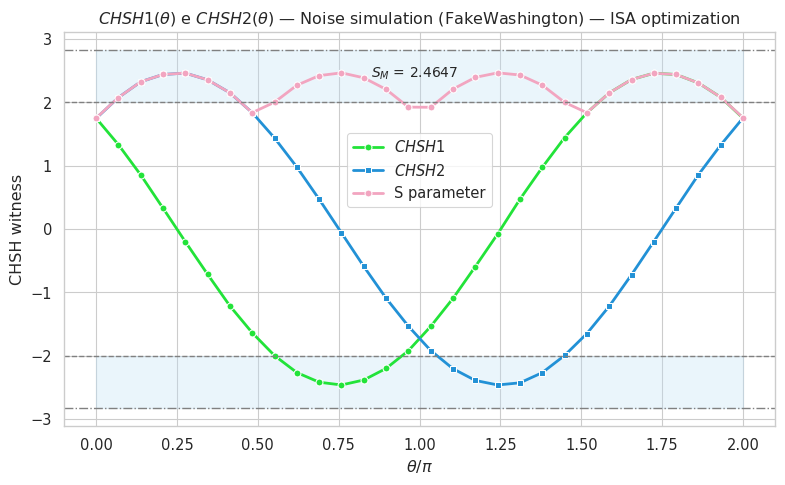

In [ ]:
# ╔═══════════════════════════════════════════════╗
# ║ 9. PLOT & POSTPROCESSING: CHSH witness vs θ/π ║
# ╚═══════════════════════════════════════════════╝

sns.set_theme(context='paper', style='whitegrid', palette='bright', font_scale=1.2)
plt.figure(figsize=(8, 5))


# Plot CHSH1 e CHSH2
sns.lineplot(
    x=phases / np.pi,
    y=chsh1_vals,
    marker='o',
    linewidth=2,
    label=r'$CHSH1$',
    color='#22e339',
    markersize=5
)
sns.lineplot(
    x=phases / np.pi,
    y=chsh2_vals,
    marker='s',
    linewidth=2,
    label=r'$CHSH2$',
    color='#2291d6',
    markersize=5
)
sns.lineplot(x=phases/pi,
             y=S_values,
             marker='o',
             linewidth=2,
             label='S parameter',
             color='#f2a5c0',
             markersize=5)

# Classical limits lines ±2
plt.axhline(y=2, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=-2, linestyle='--', color='gray', linewidth=1)

# Quantum limits lines ±2√2
limit = 2 * np.sqrt(2)
plt.axhline(y=limit, linestyle='-.', color='gray', linewidth=1)
plt.axhline(y=-limit, linestyle='-.', color='gray', linewidth=1)

# Quantum violation regions
plt.fill_between(phases / np.pi, 2, limit, color='#bcdff5', alpha=0.3)
plt.fill_between(phases / np.pi, -2, -limit, color='#bcdff5', alpha=0.3)

# Title & labels
plt.xlabel(r'$\theta / \pi$')
plt.ylabel('CHSH witness')
plt.title(r'$CHSH1(\theta)$ e $CHSH2(\theta)$ — Noise simulation (FakeWashington) — ISA optimization')

# Legend & layout
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.65), frameon=True)
plt.tight_layout()
# Max S value show
max_idx = np.argmax(S_values)
plt.annotate(f'$S_M$ = {S_max:.4f}',
             xy=(phases[max_idx]/pi, S_values[max_idx]),
             xytext=(0.85, 2.4),
             fontsize=10)
plt.savefig(
    "Noise_chsh_witness.svg",
    format="svg",
    bbox_inches="tight"
)
plt.show()